In [10]:
import random

import pandas as pd
import numpy as np

import os
import sys

import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

# to play the audio files
from IPython.display import Audio
from pydub import AudioSegment
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization
from keras.callbacks import ReduceLROnPlateau
from keras.utils import np_utils, to_categorical
from keras.callbacks import ModelCheckpoint
import openpyxl
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow

In [11]:
import warnings

if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)


In [12]:
# Path for Ravdess dataset
ravdess = "datasets/RavdevsLow"

In [13]:
ravdess_directory_list = os.listdir(ravdess)
file_emotion = []
file_path = []
for dir in ravdess_directory_list:

    actor = os.listdir(ravdess + "/" + dir)
    for file in actor:
        part = file.split('.')[0]
        part = part.split('-')
        # third part in each file represents the emotion associated to that file.
        file_emotion.append(int(part[2]))
        file_path.append(ravdess + "/" + dir + '/' + file)

# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Ravdess_df = pd.concat([emotion_df, path_df], axis=1)

# changing integers to actual emotions.
Ravdess_df.Emotions.replace({1: 'neutral', 2: 'neutral', 3: 'happy', 4: 'sad',
                             5: 'angry', 6: 'fear', 7: 'disgust', 8: 'surprise'}, inplace=True)
Ravdess_df.head()
print(Ravdess_df.shape)


(1440, 2)


In [14]:
emotionCount = {}
for i in Ravdess_df.index:
    emotions = Ravdess_df["Emotions"][i]
    if emotions in emotionCount:
        emotionCount[emotions] += 1
    else:
        emotionCount[emotions] = 1
emotionCount = dict(sorted(emotionCount.items(), key=lambda x: x[0]))
print(emotionCount)

{'angry': 192, 'disgust': 192, 'fear': 192, 'happy': 192, 'neutral': 288, 'sad': 192, 'surprise': 192}


In [15]:
smallCount = min(emotionCount.values())
print(smallCount)

192


In [16]:
counts = Ravdess_df['Emotions'].value_counts()

# find the minimum count
min_count = counts.min()

# create a list to store the balanced dataframes
balanced_dfs = []

# iterate over the emotions
for emotion in counts.index:
    # subset the data for the current emotion to have the minimum count
    balanced_df = Ravdess_df[Ravdess_df['Emotions'] == emotion].head(min_count)
    balanced_dfs.append(balanced_df)

# concatenate all the balanced dataframes into one final dataframe
final_df = pd.concat(balanced_dfs)
Ravdess_df = final_df
Ravdess_df


,Emotions,Path
0,neutral,datasets/RavdevsLow/Actor_01/03-01-01-01-01-01...
1,neutral,datasets/RavdevsLow/Actor_01/03-01-01-01-01-02...
2,neutral,datasets/RavdevsLow/Actor_01/03-01-01-01-02-01...
3,neutral,datasets/RavdevsLow/Actor_01/03-01-01-01-02-02...
4,neutral,datasets/RavdevsLow/Actor_01/03-01-02-01-01-01...
...,...,...
1435,surprise,datasets/RavdevsLow/Actor_24/03-01-08-01-02-02...
1436,surprise,datasets/RavdevsLow/Actor_24/03-01-08-02-01-01...
1437,surprise,datasets/RavdevsLow/Actor_24/03-01-08-02-01-02...
1438,surprise,datasets/RavdevsLow/Actor_24/03-01-08-02-02-01...


In [17]:
emotionCount = {}
for i in Ravdess_df.index:
    emotions = Ravdess_df["Emotions"][i]
    if emotions in emotionCount:
        emotionCount[emotions] += 1
    else:
        emotionCount[emotions] = 1
emotionCount = dict(sorted(emotionCount.items(), key=lambda x: x[0]))
print(emotionCount)

{'angry': 192, 'disgust': 192, 'fear': 192, 'happy': 192, 'neutral': 192, 'sad': 192, 'surprise': 192}


In [18]:
data_path = pd.concat([Ravdess_df], axis=0)
data_path.to_csv("data_path_R.csv", index=False)
data_path.head()

,Emotions,Path
0,neutral,datasets/RavdevsLow/Actor_01/03-01-01-01-01-01...
1,neutral,datasets/RavdevsLow/Actor_01/03-01-01-01-01-02...
2,neutral,datasets/RavdevsLow/Actor_01/03-01-01-01-02-01...
3,neutral,datasets/RavdevsLow/Actor_01/03-01-01-01-02-02...
4,neutral,datasets/RavdevsLow/Actor_01/03-01-02-01-01-01...


In [19]:
emotionList = pd.read_csv("data_path_R.csv")
emotions = emotionList["Emotions"]
emotionCount = {}
for item in emotions:
    if item in emotionCount:
        emotionCount[item] += 1
    else:
        emotionCount[item] = 1
emotionCount = dict(sorted(emotionCount.items(), key=lambda x: x[0]))
print(emotionCount)

{'angry': 192, 'disgust': 192, 'fear': 192, 'happy': 192, 'neutral': 192, 'sad': 192, 'surprise': 192}


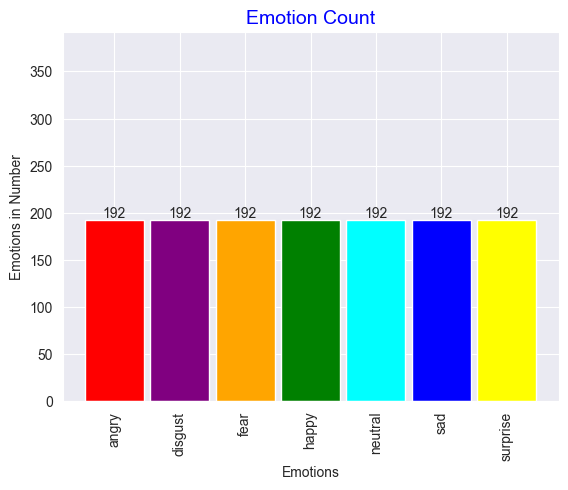

In [20]:
plt.bar(emotionCount.keys(), emotionCount.values(), width=0.9, align="center",
        color=["red", "purple", "orange", "green", "cyan", "blue", "yellow"])
plt.xlabel("Emotions")
plt.xticks(rotation=90)
plt.ylabel("Emotions in Number")
plt.title("Emotion Count", size=14, color="Blue")
plt.ylim([0, max(emotionCount.values()) + 200])
lst = []
for item in emotionCount:
    plt.text(item, emotionCount[item],
             emotionCount[item], ha="center", va="bottom")

# emotionCount.values()

# for index, value in enumerate(emotionCount)
# for index,value in enumerate(emotionCount.values()):
#     plt.text(value,index,value)
# plt.show()


In [21]:
def create_waveplot(data, sr, e):
    plt.figure(figsize=(10, 3))
    plt.title('Waveplot for audio with {} emotion'.format(e), size=15)
    librosa.display.waveshow(data, sr=sr)
    plt.show()


def create_spectrogram(data, sr, e):
    # stft function converts the data into short term fourier transform
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(12, 3))
    plt.title('Spectrogram for audio with {} emotion'.format(e), size=15)
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')
    # librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='log')
    plt.colorbar()


In [22]:
def noise(data):
    noise_amp = 0.035 * np.random.uniform() * np.amax(data)
    data = data + noise_amp * np.random.normal(size=data.shape[0])
    return data


def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate)


def shift(data):
    shift_range = int(np.random.uniform(low=-5, high=5) * 1000)
    return np.roll(data, shift_range)


def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data, sampling_rate, pitch_factor)


def volumeAdd(data):
    songData = AudioSegment.from_wav(data)
    print("sing", songData)
    songDataSamples = np.array(songData.get_array_of_samples())
    songHighVolumed = songDataSamples - 10000.0
    print(songHighVolumed)
    return songHighVolumed


datasets/RavdevsLow/Actor_01/03-01-01-01-01-02-01.wav


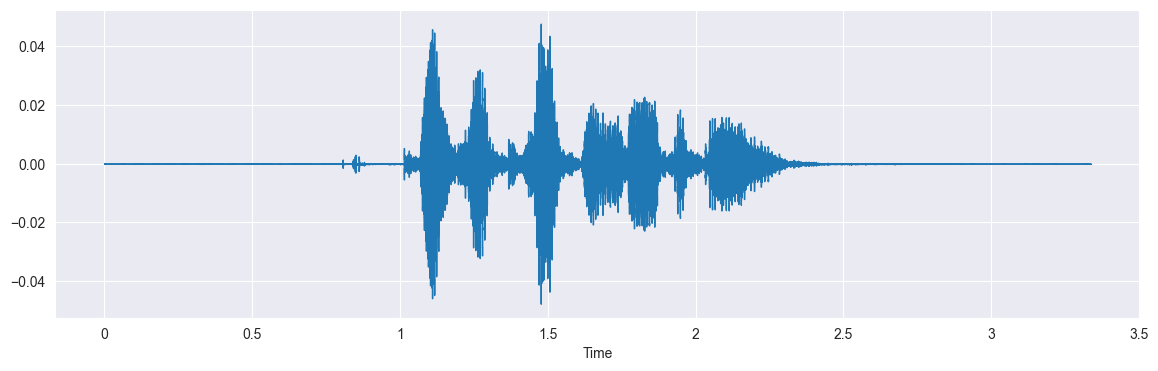

In [23]:
# taking any example and checking for techniques.
path = np.array(data_path.Path)[1]
print(path)
data, sample_rate = librosa.load(path)
plt.figure(figsize=(14, 4))
librosa.display.waveshow(y=data, sr=sample_rate)
Audio(path)


In [24]:
def extract_features(data):
    # ZCR
    result = np.array([])
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
    result = np.hstack((result, zcr))  # stacking horizontally

    # Chroma_stft
    stft = np.abs(librosa.stft(data))
    chroma_stft = np.mean(librosa.feature.chroma_stft(
        S=stft, sr=sample_rate).T, axis=0)
    result = np.hstack((result, chroma_stft))  # stacking horizontally

    # MFCC
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mfcc))  # stacking horizontally

    # Root Mean Square Value
    rms = np.mean(librosa.feature.rms(y=data).T, axis=0)
    result = np.hstack((result, rms))  # stacking horizontally

    # MelSpectogram
    mel = np.mean(librosa.feature.melspectrogram(
        y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mel))  # stacking horizontally

    return result


def get_features(path):
    # duration and offset are used to take care of the no audio in start and the ending of each audio files as seen above.
    data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)

    # without augmentation
    res1 = extract_features(data)
    result = np.array(res1)

    # data with noise
    noise_data = noise(data)
    res2 = extract_features(noise_data)
    result = np.vstack((result, res2))  # stacking vertically

    # data with stretching and pitching
    new_data = stretch(data)
    data_stretch_pitch = pitch(new_data, sample_rate)
    res3 = extract_features(data_stretch_pitch)
    result = np.vstack((result, res3))  # stacking vertically

    return result


Uncomment for extracting features, from here

In [25]:
# X, Y = [], []
# for path, emotion in zip(data_path.Path, data_path.Emotions):
#     try:
#         feature = get_features(path)
#     except:
#         print(path)
#         print(emotion)
#     for ele in feature:
#         try:
#             X.append(ele)
#             # appending emotion 3 times as we have made 3 augmentation techniques on each audio file.
#             Y.append(emotion)
#         except:
#             print(ele)

In [26]:
# len(X), len(Y), data_path.Path.shape

In [27]:
# Features = pd.DataFrame(X)
# Features['labels'] = Y
# Features.to_excel('features_R.xlsx', index=False)
# Features.head()


In [28]:
# X = Features.iloc[:, :-1].values
# Y = Features['labels'].values

to here

In [29]:
features_df = pd.read_excel("features_R.xlsx")

In [44]:
emotionsfromFeatures = features_df['labels']
emotionCountfromFeatures = {}
for item in emotionsfromFeatures:
    if item in emotionCountfromFeatures:
        emotionCountfromFeatures[item] += 1
    else:
        emotionCountfromFeatures[item] = 1
print(emotionCountfromFeatures)

{'neutral': 576, 'happy': 576, 'sad': 576, 'angry': 576, 'fear': 576, 'disgust': 576, 'surprise': 576}


In [56]:
featuresofit = np.asarray(features_df.iloc[:, :-1].values)
X = featuresofit
labelofit = np.asarray(features_df['labels'])
Y = labelofit

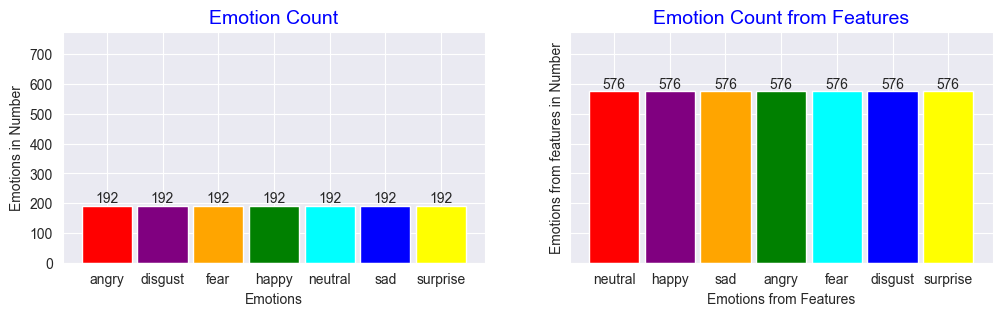

In [57]:
fig, (plt1, plt2) = plt.subplots(1, 2, sharey=True, figsize=(12, 3))
plt1.bar(emotionCount.keys(), emotionCount.values(), width=0.9, align="center",
         color=["red", "purple", "orange", "green", "cyan", "blue", "yellow"])
plt1.set_xlabel("Emotions")
plt1.set_ylabel("Emotions in Number")
plt1.set_title("Emotion Count", size=14, color="Blue")
plt1.set_ylim([0, max(emotionCount.values()) + 200])
# lst = []
for item in emotionCount:
    plt1.text(item, emotionCount[item],
              emotionCount[item], ha="center", va="bottom")

plt2.bar(emotionCountfromFeatures.keys(), emotionCountfromFeatures.values(), width=0.9, align="center",
         color=["red", "purple", "orange", "green", "cyan", "blue", "yellow"])
plt2.set_xlabel("Emotions from Features")
plt2.set_ylabel("Emotions from features in Number")
plt2.set_title("Emotion Count from Features", size=14, color="Blue")
plt2.set_ylim([0, max(emotionCountfromFeatures.values()) + 200])
# lst = []
for item in emotionCountfromFeatures:
    plt2.text(item, emotionCountfromFeatures[item],
              emotionCountfromFeatures[item], ha="center", va="bottom")
# plt2.subplots(nrows=1,ncols=2)

In [68]:
from sklearn.preprocessing import MinMaxScaler
scalar = MinMaxScaler()
X = scalar.fit_transform(X)
X

array([[4.91861241e-01, 6.55560187e-01, 7.05457273e-01, ...,
        9.52433981e-16, 7.98080949e-16, 8.69149333e-16],
       [8.05483656e-01, 8.62706266e-01, 9.29309878e-01, ...,
        1.23250724e-03, 1.16158774e-03, 1.24490548e-03],
       [3.29777185e-01, 5.13281191e-01, 6.57388716e-01, ...,
        2.15630932e-14, 1.87638232e-14, 1.92625436e-14],
       ...,
       [3.90687125e-01, 5.47151349e-01, 4.68200788e-01, ...,
        1.54891888e-09, 1.38073862e-09, 1.49161349e-09],
       [7.13408939e-01, 6.52700852e-01, 6.46360988e-01, ...,
        1.34484344e-02, 1.24348666e-02, 1.34415211e-02],
       [3.04053369e-01, 5.71502497e-01, 5.45762329e-01, ...,
        8.26813783e-10, 4.25862058e-10, 3.27022855e-10]])

In [69]:
from sklearn.feature_selection import SelectKBest, chi2
chi2_selector = SelectKBest(chi2, k=100)
X_new = chi2_selector.fit_transform(X, Y)
X_new

array([[2.48914548e-01, 1.81624199e-02, 2.10491103e-03, ...,
        9.52433981e-16, 7.98080949e-16, 8.69149333e-16],
       [5.54569122e-01, 2.21245441e-02, 2.10603159e-03, ...,
        1.23250724e-03, 1.16158774e-03, 1.24490548e-03],
       [1.68284164e-01, 8.06862198e-03, 4.76372595e-04, ...,
        2.15630932e-14, 1.87638232e-14, 1.92625436e-14],
       ...,
       [4.92055273e-01, 1.15029749e-01, 1.36277172e-02, ...,
        1.54891888e-09, 1.38073862e-09, 1.49161349e-09],
       [7.27030103e-01, 1.24057461e-01, 1.39424918e-02, ...,
        1.34484344e-02, 1.24348666e-02, 1.34415211e-02],
       [4.25996106e-01, 5.76200581e-02, 1.89173921e-03, ...,
        8.26813783e-10, 4.25862058e-10, 3.27022855e-10]])

In [70]:
# print(Y)
x_train, x_test, y_train, y_test = train_test_split(
    X, Y, random_state=0, test_size=0.1, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape
# pd.DataFrame(Y)

((3628, 162), (3628,), (404, 162), (404,))

In [73]:
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_train.shape, y_train.shape, x_test.shape, y_test.shape
x_train

array([[-0.60373392, -2.24634934, -2.8083158 , ..., -0.17740602,
        -0.17686084, -0.17648884],
       [ 0.06530276,  0.64851715,  1.27185975, ..., -0.06792933,
        -0.06810774, -0.07166724],
       [-0.79568783, -0.33544112,  0.03113954, ..., -0.17740602,
        -0.17686084, -0.17648884],
       ...,
       [-0.64306607, -1.1328703 , -0.29130534, ..., -0.17740559,
        -0.17686042, -0.17648844],
       [-0.54236276,  0.56800485,  0.24651674, ..., -0.17740602,
        -0.17686084, -0.17648884],
       [-0.24033082, -2.49629534, -2.24600578, ..., -0.17740601,
        -0.17686084, -0.17648884]])

In [77]:
kernelchoice = ["rbf"]
C_choice = [150, 200, 250, 300, 350]
# C_choice = [0.5, 0.6, 0.8, 0.9, 1]
import random

In [ ]:
from sklearn import svm
from sklearn.metrics import accuracy_score
from sklearn.multiclass import OneVsRestClassifier

for i in C_choice:
    a = random.choice(kernelchoice)
    b = random.choice(C_choice)
    classifier = svm.SVC(kernel='linear', gamma="auto", C=b)
    classifier = OneVsRestClassifier(classifier)
    classifier.fit(x_train, y_train)
    y_predict = classifier.predict(x_test)
    accuracyPercent = accuracy_score(y_test, y_predict) * 100
    print("Kernel:  " + str(a) + "  ||  " + " C: " + str(b) + "  ||  Accuracy" + "  :  " + str(accuracyPercent))

Kernel:  rbf  ||   C: 350  ||  Accuracy  :  53.71287128712871
Kernel:  rbf  ||   C: 150  ||  Accuracy  :  53.960396039603964
Kernel:  rbf  ||   C: 250  ||  Accuracy  :  53.21782178217822


In [ ]:
print(classification_report(y_test, y_predict))